In [ ]:
include("../Ising_model/IsingCore.jl")
using .IsingCore
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, ProgressMeter
using CairoMakie

init_logger(dir="../../logs", level=:Info)
println(names(IsingCore))

[:IsingCore, :calc_acceptance_and_rtt, :calc_energy, :initial_state, :metropolis_sampler, :uniform_acceptance_grad_sm]


In [ ]:
N = 6
β_min = 0
β_max = 1
M = 6
mcSteps=10^3
eqSteps=10^2
# target = 0.23
η = 0.001
epochs = 300
batch_size = 5

@info """
Hyperparameters of Ising model:
--------------------
system size: $(N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [ ]:
init_β_ladder = Utils.set_temperature_ladder(β_min, β_max; M=M)
exchange_prob_means, _ = IsingCore.calc_acceptance_and_rtt(N, init_β_ladder)

println(init_β_ladder)
println(exchange_prob_means)

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
[0.2050084274652103, 0.09174632709951411, 0.1532514537786105, 0.734925243169881, 0.9609240499768903]


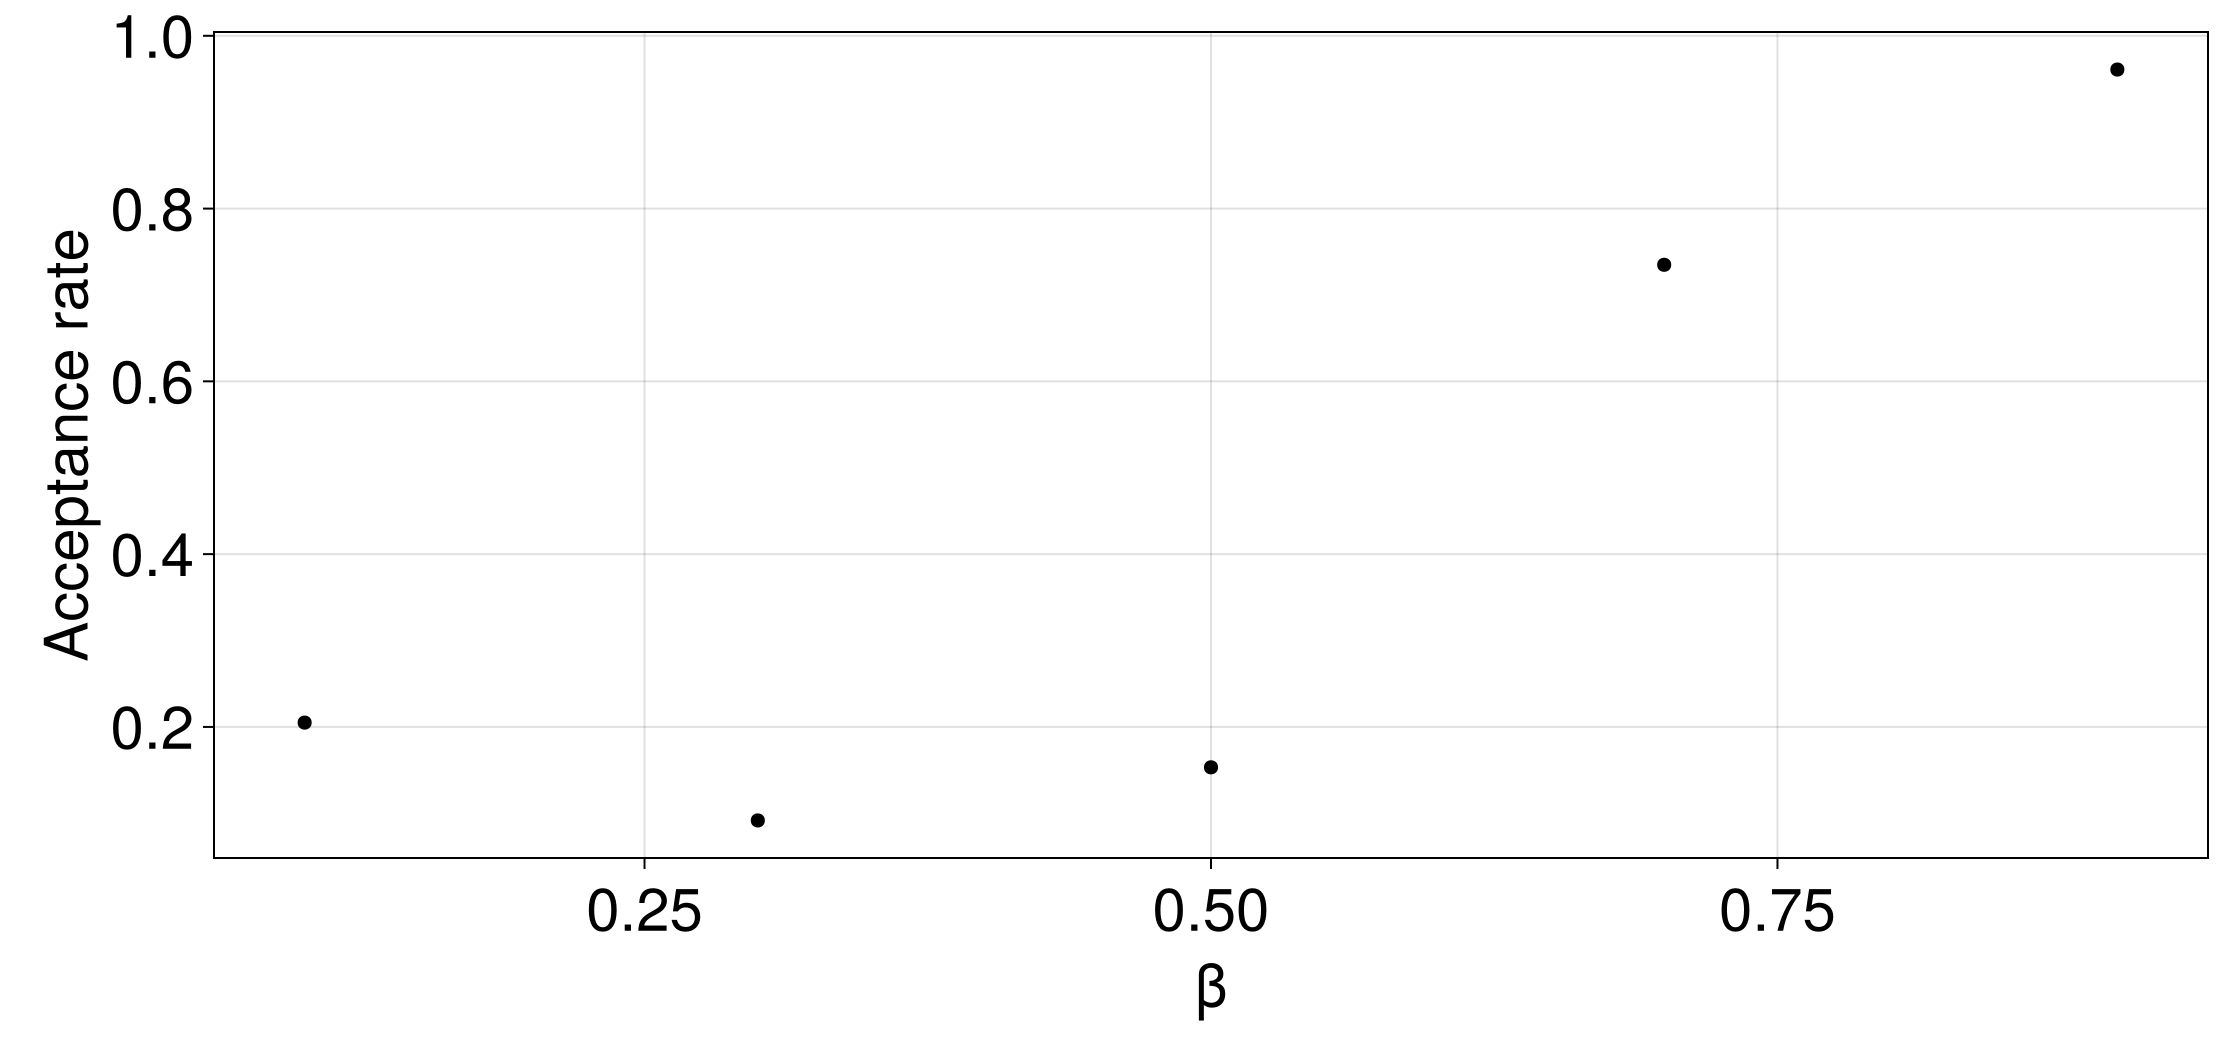

CairoMakie.Screen{IMAGE}


In [ ]:
begin
    fig1 = Figure(size=(1120, 525), fontsize = 30)
    ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
    scatter!(ax1, init_β_ladder[1:(end-1)], exchange_prob_means, color=:black, markersize=10)
    
    display(fig1)
end

In [ ]:
β_ladder = deepcopy(init_β_ladder)
β_ladder_trace = [β_ladder]
optimizer = Momentum(η, 0.9) # Momentum
setup = Optimisers.setup(optimizer, β_ladder)

exchange_prob_trace = [exchange_prob_means]
init_loss = Statistics.var(exchange_prob_means)
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = IsingCore.score_method(
            N, 
            β_ladder;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=1,
            # target=target
        )
        push!(samples, grad)
    end
    loss_func = Statistics.var(exchange_prob_means)
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)

    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)
    grad_mean[end] = 0.0
    setup, β_ladder = Optimisers.update(setup, β_ladder, grad_mean)

    push!(β_ladder_trace, deepcopy(β_ladder))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5))±$(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


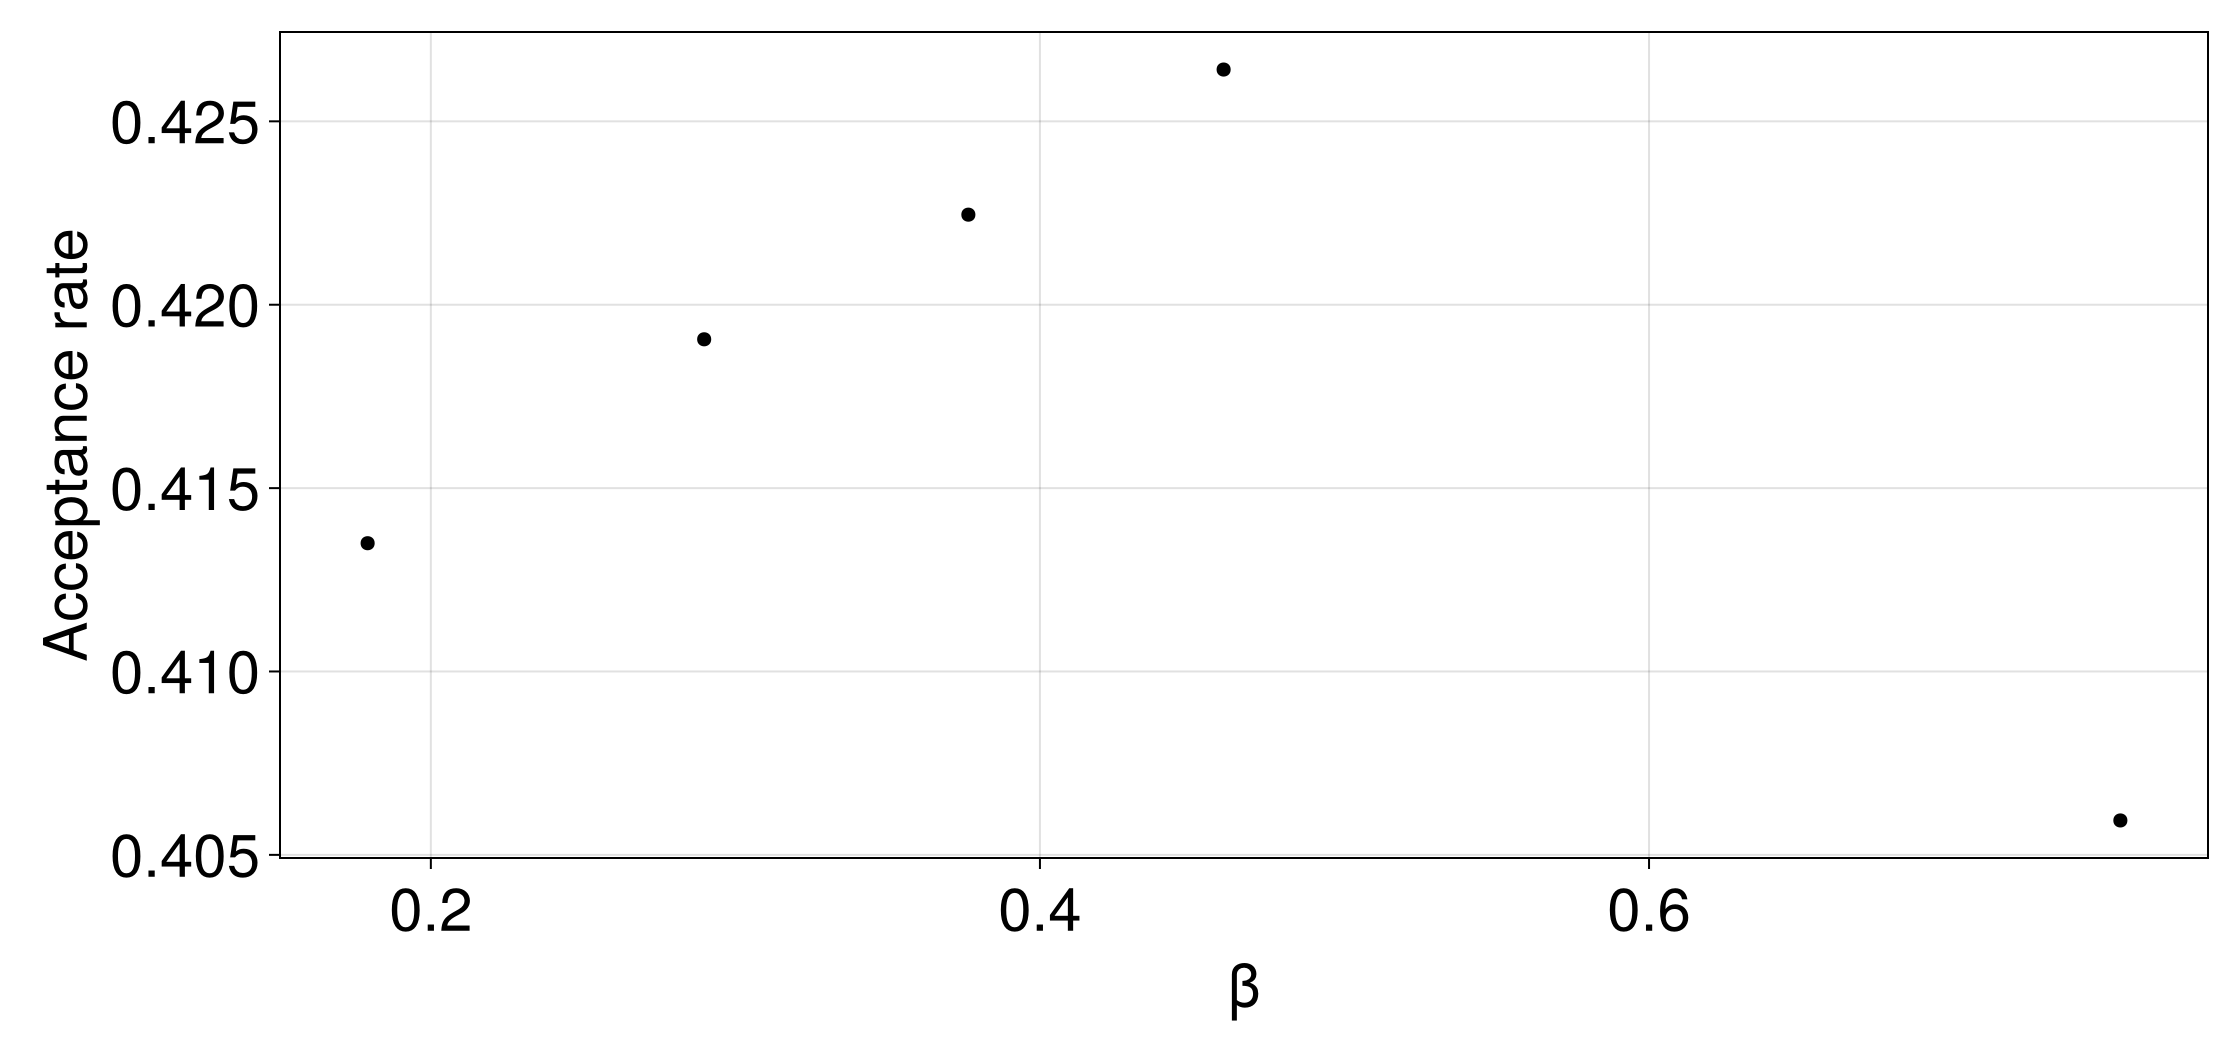

CairoMakie.Screen{IMAGE}


In [ ]:
begin
    fig1 = Figure(size=(1120, 525), fontsize = 30)
    ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
    scatter!(ax1, β_ladder_trace[end][1:(end-1)], exchange_prob_means, color=:black, markersize=10)
    
    display(fig1)
end

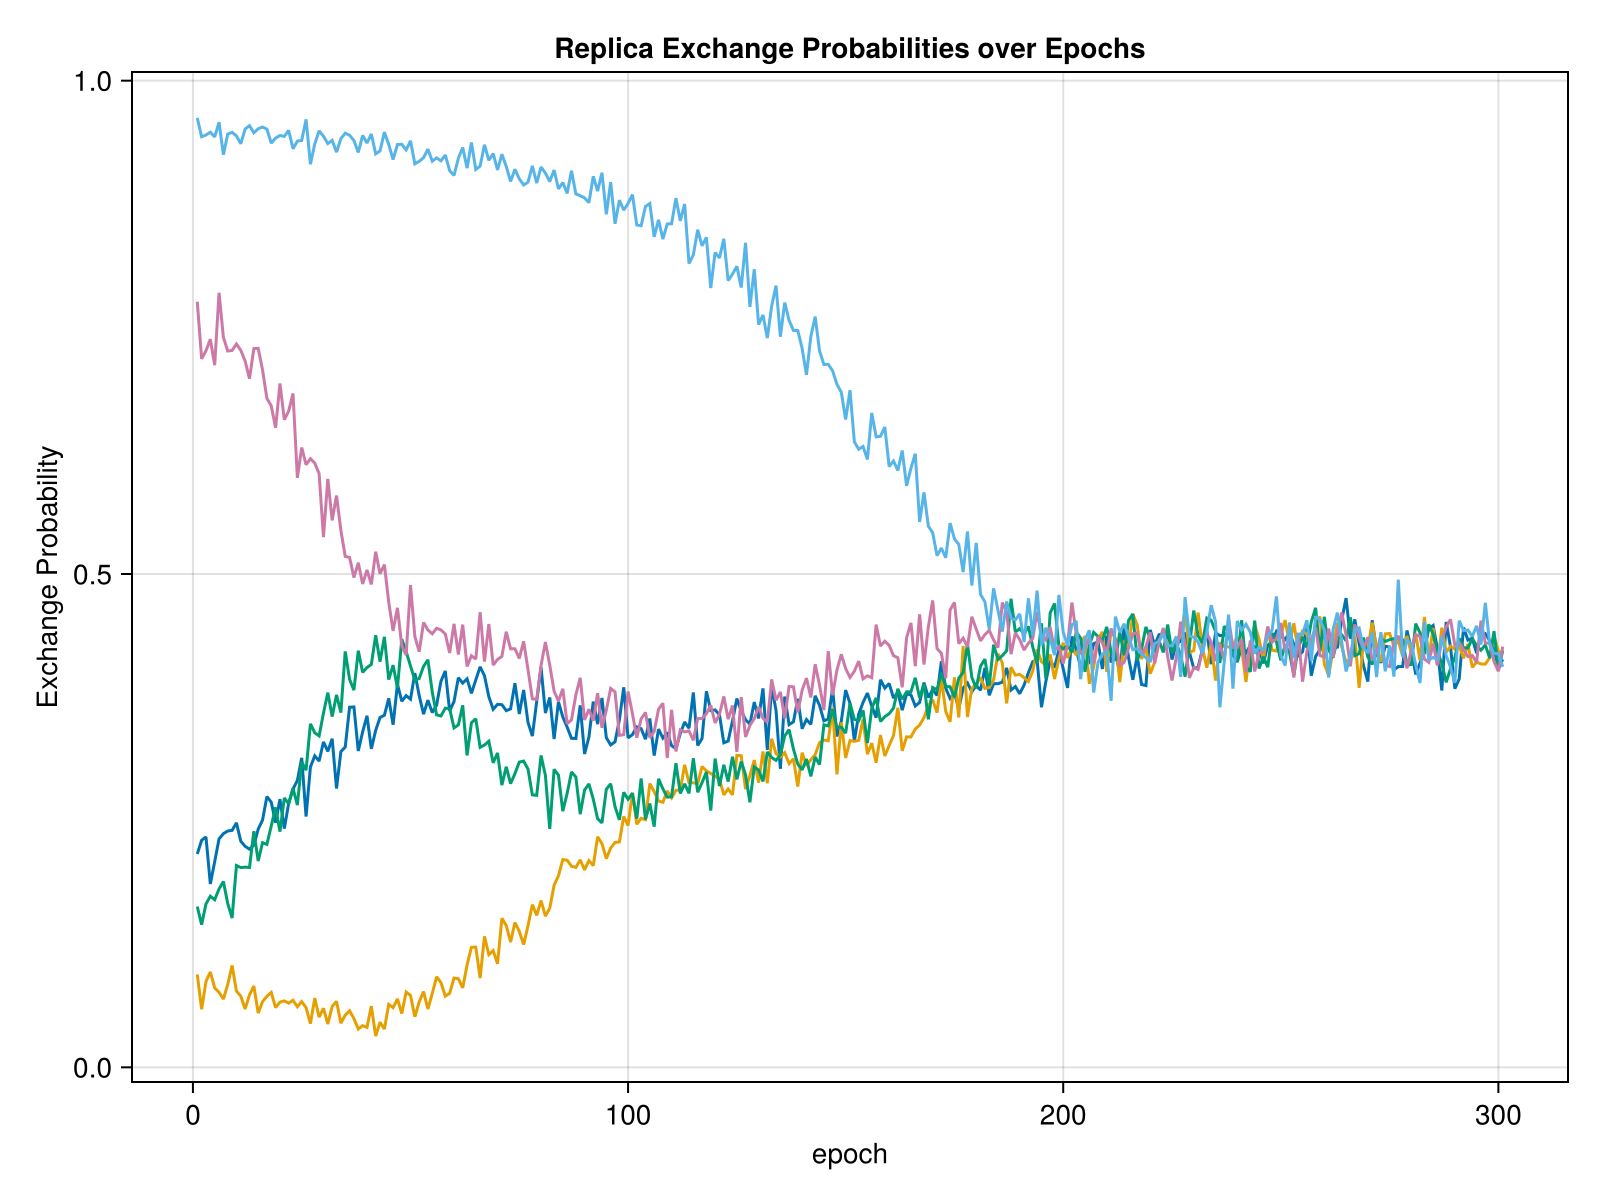

CairoMakie.Screen{IMAGE}


In [ ]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size = (800, 600))
ax2  = Axis(
    fig2[1, 1], 
    title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "epoch", 
    ylabel = "Exchange Probability"
)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i")
end

# axislegend(ax2; position = :rt)
display(fig2)

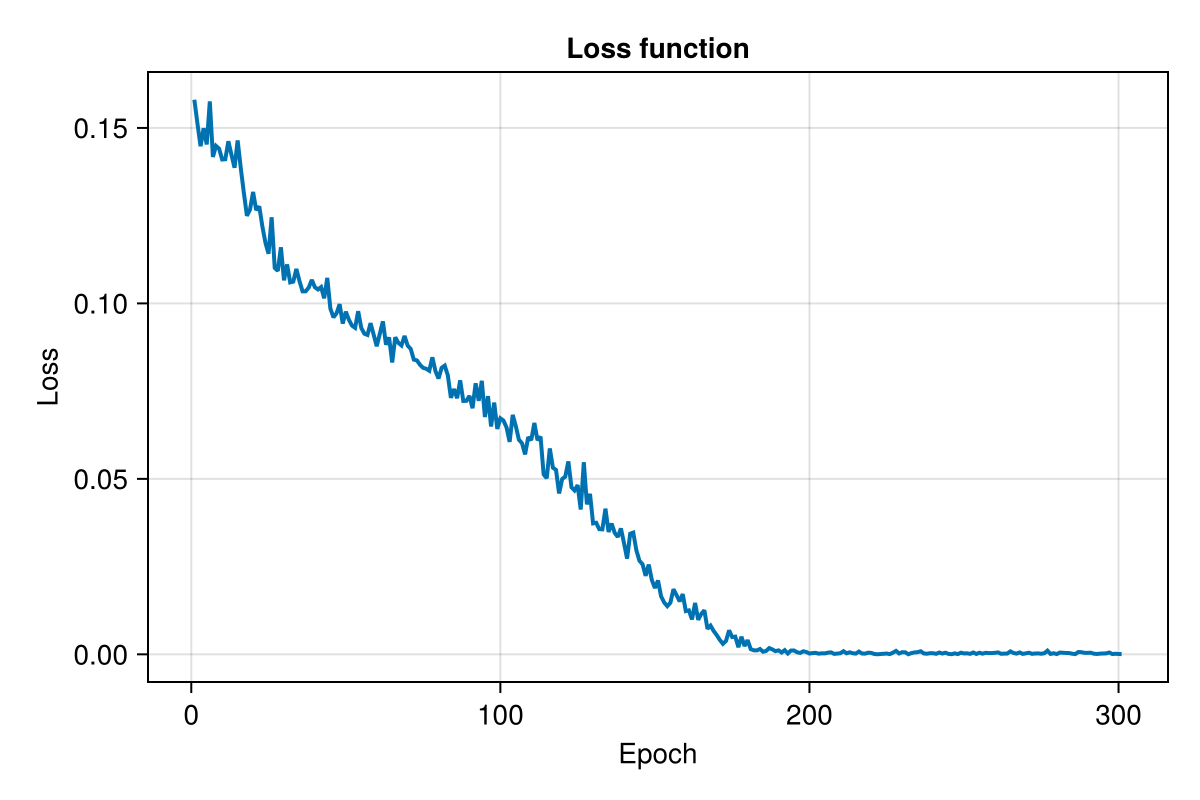

CairoMakie.Screen{IMAGE}


In [10]:
fig3 = Figure(size = (600, 400))
ax3 = Axis(fig3[1, 1]; title  = "Loss function", xlabel = "Epoch", ylabel = "Loss")
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)